# House Price Prediction in NYC 

In [28]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import datetime 

os.chdir('/Users/willychien/20FDS/assignment_2/')
print(os.getcwd())

/Users/willychien/20FDS/assignment_2


In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
# Import the historical dataset
df = pd.read_csv("sales_data_2015.csv", index_col=0, low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84768 entries, 0 to 84767
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sale_id     84768 non-null  int64  
 1   bbl_id      84768 non-null  int64  
 2   year        84768 non-null  int64  
 3   borough     84768 non-null  int64  
 4   bldg_ctgy   84768 non-null  object 
 5   tax_cls_p   84765 non-null  object 
 6   block       84768 non-null  int64  
 7   lot         84768 non-null  int64  
 8   easmnt      1 non-null      object 
 9   bldg_cls_p  84765 non-null  object 
 10  address     84768 non-null  object 
 11  apt         20983 non-null  object 
 12  zip         84768 non-null  int64  
 13  res_unit    84768 non-null  int64  
 14  com_unit    84768 non-null  int64  
 15  tot_unit    84768 non-null  int64  
 16  land_sqft   84768 non-null  int64  
 17  tot_sqft    84768 non-null  int64  
 18  yr_built    84768 non-null  int64  
 19  tax_cls_s   84768 non-nul

In [5]:
# Check the missing values 

miss=df.isnull().sum()/len(df)
miss=miss[miss>0]
miss.sort_values(inplace=True)
miss

tax_cls_p     0.000035
bldg_cls_p    0.000035
apt           0.752466
easmnt        0.999988
dtype: float64

In [6]:
# Considering the amount of missing vlaues, dropping them instead replacing them by mean/median would be less noisy 
# Remove the columns without relevence and too much NaN

drop_columns = ["easmnt", "year", "address", "apt", "usable"] #>50% apt are NAN, drop it first
df2 = df.drop(drop_columns, axis = 1)
df2.shape

(84768, 21)

In [7]:
# Remove some absurb values 

df2 = df2[(df2.yr_built != 0) & (df2.tot_sqft != 0) & (df2.price != 0) & (df2.yr_built >= 0)]
df2.shape

(28711, 21)

In [9]:
# Extract datatime value to months only 

df2['sale_date'] = pd.to_datetime(df2.sale_date)
df2['sale_date'] = df2['sale_date'].dt.strftime('%d-%m-%y')
df2["mth"] = df2['sale_date'].apply(lambda x: x.split("-")[1])

df2.head()

,Sale_id,bbl_id,borough,bldg_ctgy,tax_cls_p,block,lot,bldg_cls_p,zip,res_unit,...,land_sqft,tot_sqft,yr_built,tax_cls_s,bldg_cls_s,sale_date,price,long,lat,mth
4,5,2303936,2,01 ONE FAMILY DWELLINGS,1,3039,36,S1,10458,1,...,2500,2452,1910,1,S1,01-07-15,400000,-73.893338,40.856136,07
7,8,22912139,2,02 TWO FAMILY DWELLINGS,1,2912,139,B1,10457,2,...,2000,2400,1993,1,B1,04-08-15,430000,-73.901430,40.837883,08
8,9,22912152,2,02 TWO FAMILY DWELLINGS,1,2912,152,B1,10457,2,...,2000,2400,1993,1,B1,02-06-15,10000,-73.902418,40.837337,06
9,10,22929126,2,02 TWO FAMILY DWELLINGS,1,2929,126,B1,10457,2,...,3165,2394,1995,1,B1,05-08-15,505000,-73.899782,40.838008,08
10,11,23030151,2,02 TWO FAMILY DWELLINGS,1,3030,151,S2,10457,2,...,1620,3240,1931,1,S2,28-09-15,490000,-73.895833,40.855842,09


# 1. Exploratory Data Analysis  

## 1.1 Check the normality in response variable

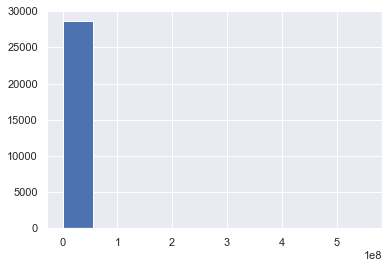

In [11]:
# Check the mormality of prediction value (price)

sns.set()
df2.price.hist()

In [12]:
# As the previous plot seems to have some extreme outliers, 
# discarding the extreme outliers would make it more readable

# Set up the quantile 
bound = [1, 2.5, 5, 25, 50, 75, 97.5, 99]
quantile_bound = [np.percentile(df2.price , q = i) for i in bound]
print(quantile_bound)

# Only keep the price within q2.5~q97.5
df2 = df2[(df2.price >= quantile_bound[1]) & (df2.price <= quantile_bound[-2])]
df2.shape

[10.0, 500.0, 59900.0, 375000.0, 567000.0, 930500.0, 10628750.0, 24000000.0]


(27291, 22)

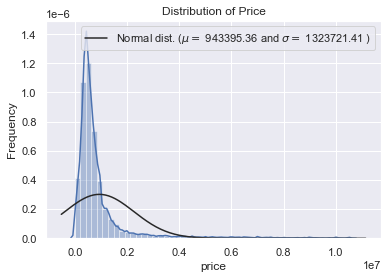

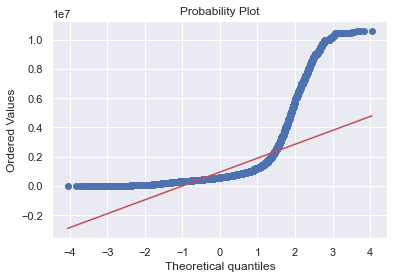

In [13]:
# After removing outliers, plotting the target value(price), which seems right skewed

sns.set()
sns.distplot(df2.price, fit=stats.norm)

# Get the fitted parameters used by the function

(mu, sigma) = stats.norm.fit(df2.price)

# plot with the distribution
plt.title("Distribution of Price", fontsize=12)
plt.legend([f'Normal dist. ($\mu=$ {round(mu,2)} and $\sigma=$ {round(sigma,2)} )'], loc='best')
plt.ylabel('Frequency')

# Probablity plot
fig = plt.figure()
stats.probplot(df2.price, plot=plt)
plt.show()

In [14]:
def plot_dist(target):
    sns.set()
    sns.distplot(target, fit=stats.norm)
    
    # Get the fitted parameters used by the function
    (mu, sigma) = stats.norm.fit(target)

    # Dist plot
    plt.title("Distibution plot", fontsize=12)
    plt.legend([f'Normal dist. ($\mu=$ {round(mu,2)} and $\sigma=$ {round(sigma,2)})'], loc='best')
    plt.ylabel('Frequency')
    
def plot_prob(target):
    sns.set()
    fig = plt.figure()
    stats.probplot(target, plot=plt)
    plt.title("Probability plot", fontsize=12)
    plt.show()

Before Transformtion


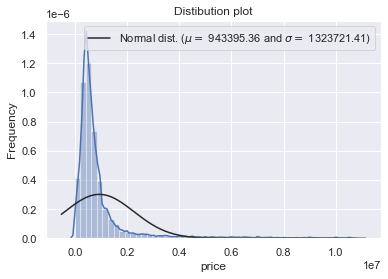

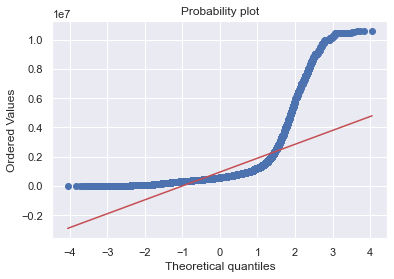

Square Root Transformtion


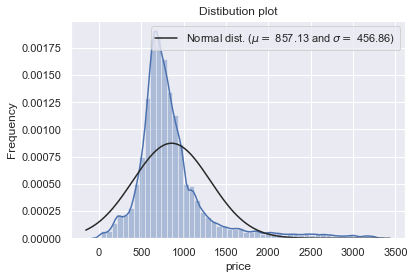

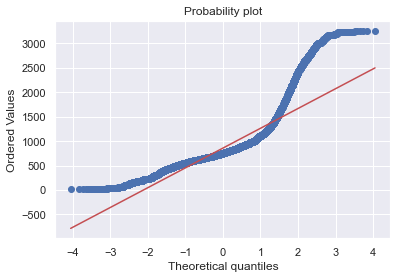

Boxcox(lmbda 0.2) Transformtion


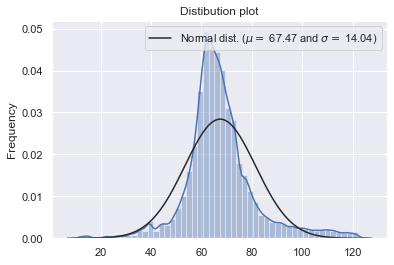

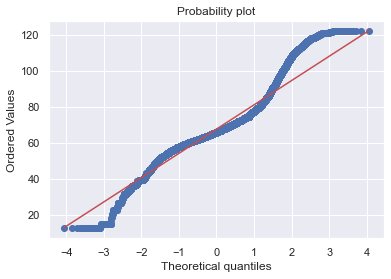

Log Transformation


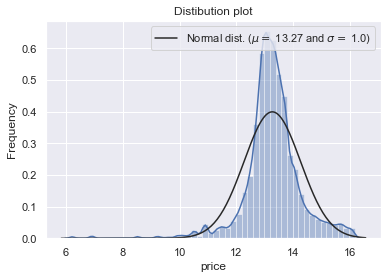

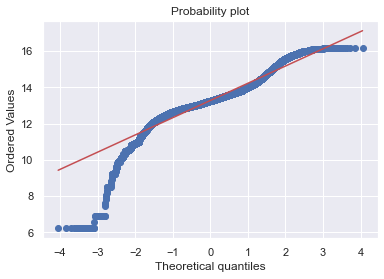

Inverse Transformation


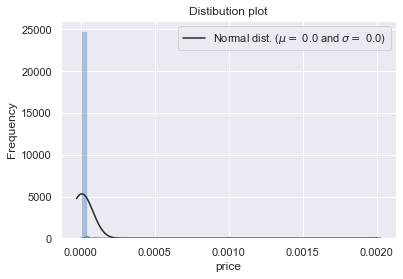

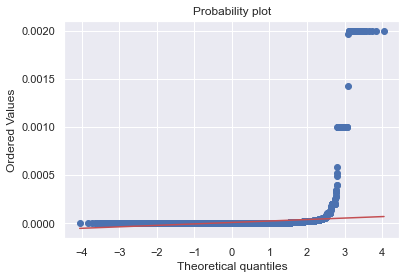

In [16]:
# Observation: distribution seems right skewed
# Considering some transformation for price, including sqrt, boxcox, log, reciprocal
# Plot different transformations and see which one looks better

trans_dict = {
    "Before Transformtion": df2["price"],
    "Square Root Transformtion":  df2["price"]**0.5,
    "Boxcox(lmbda 0.2) Transformtion": stats.boxcox(df2["price"], lmbda=0.2),  
    "Log Transformation": np.log(df2["price"]+1), 
    "Inverse Transformation": 1/df2["price"]
    }

trans_list = list(trans_dict.keys())

for t in trans_list:
    print(f"{t}")
    plot_dist(trans_dict[t])
    plot_prob(trans_dict[t])

In [17]:
# Test different transformation with Shapito test 
# As boxcox has the greatest value, applying it in the following analysis

for t in trans_list:
    shapiro_test = stats.shapiro(trans_dict[t])
    print(t, round(shapiro_test[0],3))

Before Transformtion 0.516
Square Root Transformtion 0.786
Boxcox(lmbda 0.2) Transformtion 0.922
Log Transformation 0.905
Inverse Transformation 0.041


/Users/willychien/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [18]:
# Create a column for boxcox transformed price

df2["price_trans"] = stats.boxcox(df2["price"], lmbda=0.2)
df2.head()

,Sale_id,bbl_id,borough,bldg_ctgy,tax_cls_p,block,lot,bldg_cls_p,zip,res_unit,...,tot_sqft,yr_built,tax_cls_s,bldg_cls_s,sale_date,price,long,lat,mth,price_trans
4,5,2303936,2,01 ONE FAMILY DWELLINGS,1,3039,36,S1,10458,1,...,2452,1910,1,S1,01-07-15,400000,-73.893338,40.856136,07,60.975396
7,8,22912139,2,02 TWO FAMILY DWELLINGS,1,2912,139,B1,10457,2,...,2400,1993,1,B1,04-08-15,430000,-73.901430,40.837883,08,61.936607
8,9,22912152,2,02 TWO FAMILY DWELLINGS,1,2912,152,B1,10457,2,...,2400,1993,1,B1,02-06-15,10000,-73.902418,40.837337,06,26.547867
9,10,22929126,2,02 TWO FAMILY DWELLINGS,1,2929,126,B1,10457,2,...,2394,1995,1,B1,05-08-15,505000,-73.899782,40.838008,08,64.123907
10,11,23030151,2,02 TWO FAMILY DWELLINGS,1,3030,151,S2,10457,2,...,3240,1931,1,S2,28-09-15,490000,-73.895833,40.855842,09,63.708303


## 1.2 Check the distribution in predictor variables  
Check the correlations between price and other attributes to see whether there is any colinearily or outliers Both  numerical attributes and factoral attibutes should be examined respectively.

In [19]:
# Categorize different attibutes according to their dtype and save them into different lists 

int_features = []
float_features = []
object_features = []
for dtype, feature in zip(df2.dtypes, df2.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)

print(int_features)
print(float_features)
print(object_features)

['Sale_id', 'bbl_id', 'borough', 'block', 'lot', 'zip', 'res_unit', 'com_unit', 'tot_unit', 'land_sqft', 'tot_sqft', 'yr_built', 'tax_cls_s', 'price']
['long', 'lat', 'price_trans']
['bldg_ctgy', 'tax_cls_p', 'bldg_cls_p', 'bldg_cls_s', 'sale_date', 'mth']


In [20]:
# Knowing  'borough', 'block', 'lot', 'zip', tax_cls_s' are factors instead of continuous varialbes,
# put them into factoral attibutes instead of numerical ones

misplace_feature = ['borough', 'block', 'lot', 'zip', 'tax_cls_s']
 
fac_features = object_features + misplace_feature
num_features = float_features + int_features 
num_features = [i for i in num_features if i not in  misplace_feature]

print(fac_features)
print(num_features)

['bldg_ctgy', 'tax_cls_p', 'bldg_cls_p', 'bldg_cls_s', 'sale_date', 'mth', 'borough', 'block', 'lot', 'zip', 'tax_cls_s']
['long', 'lat', 'price_trans', 'Sale_id', 'bbl_id', 'res_unit', 'com_unit', 'tot_unit', 'land_sqft', 'tot_sqft', 'yr_built', 'price']


### 1.2.1 Check continuous variables 

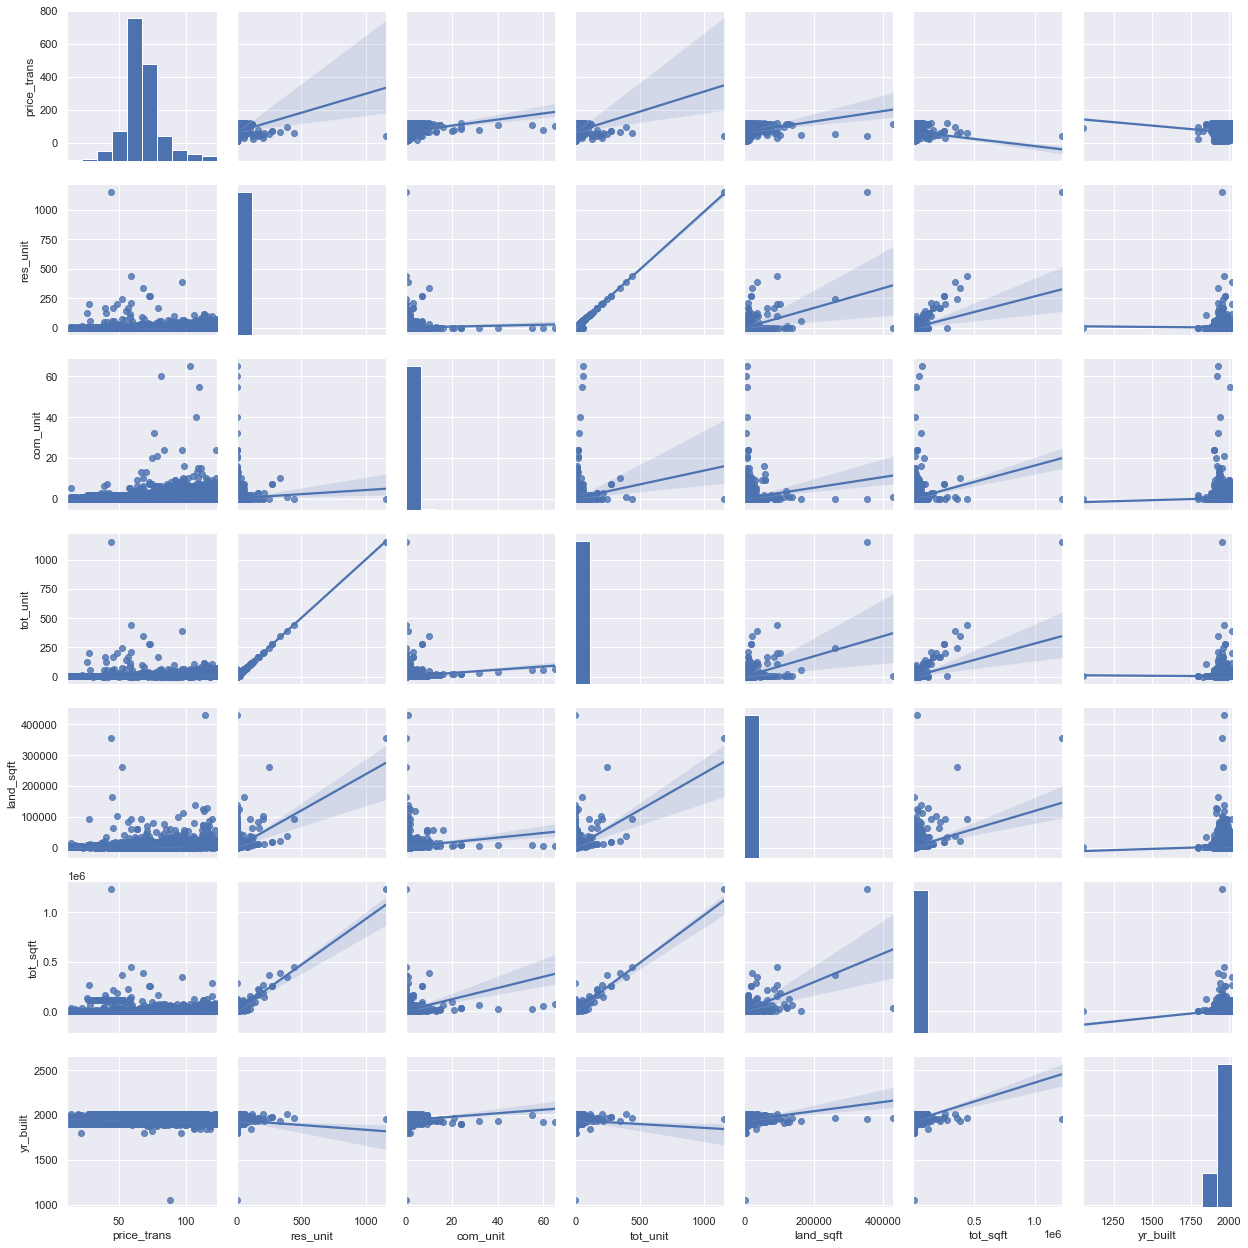

In [22]:
# Insepct data distribution in numerical 

num_features_specefic = ['price_trans', 'res_unit', 'com_unit', 'tot_unit', 'land_sqft', 'tot_sqft', 'yr_built']
sns.pairplot(df2[num_features_specefic], kind="reg")

plt.tight_layout()

### Dealing with outliers
Apparently there are some sxtreme outliers that will interfere the prediction. Dealing with outliers, two approaches were experimented: replacing outliers by medians of atrributes yields a R2 value of 22.9%, while discarding the outliers direcly imporves the R2 value to 36.4%.

In [23]:
# Check the quantile for each variables 

bound = [1, 2, 2.5, 5, 25, 50, 75, 95, 97.5, 98,  99]
check = ['res_unit', 'com_unit', 'tot_unit', 'land_sqft', 'tot_sqft', 'yr_built']

for n in check:
    quantile_bound = [np.percentile(df2[n] , q = i) for i in bound]
    print(n,":", quantile_bound)

res_unit : [0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 6.0, 11.0, 16.0, 27.0]
com_unit : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 3.0]
tot_unit : [1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 6.0, 12.0, 17.0, 28.0]
land_sqft : [946.0, 1167.8, 1240.0, 1484.5, 2000.0, 2500.0, 4000.0, 7532.0, 10250.0, 11469.800000000007, 15644.19999999991]
tot_sqft : [736.0, 864.0, 896.0, 1000.0, 1412.0, 1988.0, 2922.0, 12265.5, 58609.0, 112850.0, 112850.0]
yr_built : [1899.0, 1899.0, 1899.0, 1901.0, 1920.0, 1930.0, 1960.0, 2007.0, 2008.0, 2011.0, 2014.0]


In [24]:
# Drop the outlier by designated quantile

df3 = df2[df2.tot_sqft <= 58609.0] #q95
df3 = df3[df3.land_sqft <= 10250.0] # q97.5
df3 = df3[df3.tot_unit <= 12.00] # q97.5
df3 = df3[df3.yr_built >= 1899.0] # q1

df3.shape

(25431, 23)

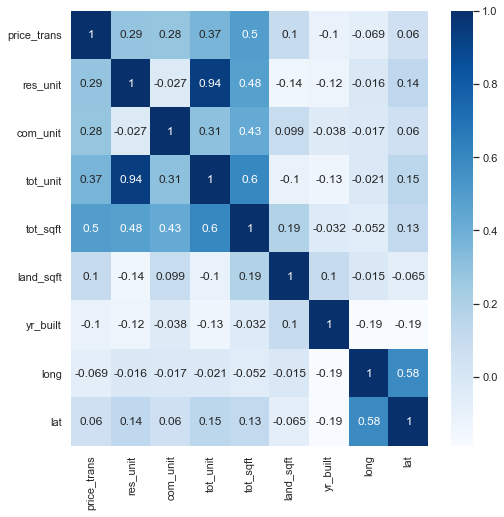

<Figure size 432x288 with 0 Axes>

In [25]:
# Draw heatmaps to inspect the correlations

def draw_corr_heatmap(dataframe, examine_list):

    corr = dataframe[examine_list].corr() 
    
    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1)
    sns.heatmap(corr, cmap="Blues", annot=True, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)
    plt.show()
    
# Correlations in Numerical attributes before transformation 

exam_list = ["price_trans", 'res_unit', 'com_unit', 'tot_unit', 'tot_sqft','land_sqft', 'yr_built', 'long', 'lat']
draw_corr_heatmap(df3, exam_list)
plt.tight_layout()

### 1.2.2 Inspect factoral attibutes 

In [29]:
# Check correlations for factoral attributes

import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [30]:
# Check the correlations between factors and price_root
print("Correlations in categorical features:")
for i in fac_features:
    corr = cramers_v(df3.price_trans, df3[i])
    print(i, ":", round(corr,3))

Correlations in categorical features:
bldg_ctgy : 0.405
tax_cls_p : 0.397
bldg_cls_p : 0.349
bldg_cls_s : 0.344
sale_date : 0.149
mth : 0.053
borough : 0.389
block : 0.0
lot : 0.0
zip : 0.265
tax_cls_s : 0.373


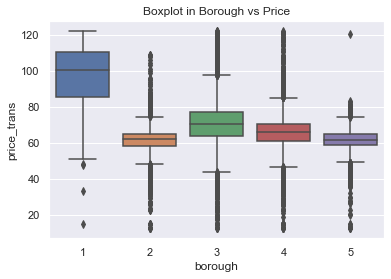

In [193]:
# Can also visually examine 

plt.subplots(figsize=(6,4))
plt.title("Boxplot in Borough vs Price")
sns.boxplot(x = df3.borough, y = df3.price_trans)

In [37]:
def pairplot_single(self, x_, y_, h_):
    sns.lmplot(x= x_, y= y_, hue=h_, data= self, fit_reg=False)

def pairplot_all(self, cols, h): 
    plt.figure(figsize=(10,6))
    g = sns.pairplot(self[cols], hue=h,size=2)
    g.set(xticklabels=[]) 

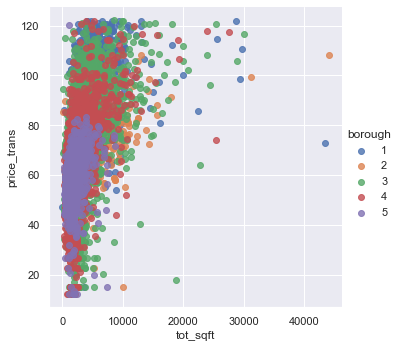

In [38]:
pairplot_single(df3, 'tot_sqft', 'price_trans', 'borough')

/Users/willychien/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/willychien/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/willychien/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/willychien/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<Figure size 720x432 with 0 Axes>

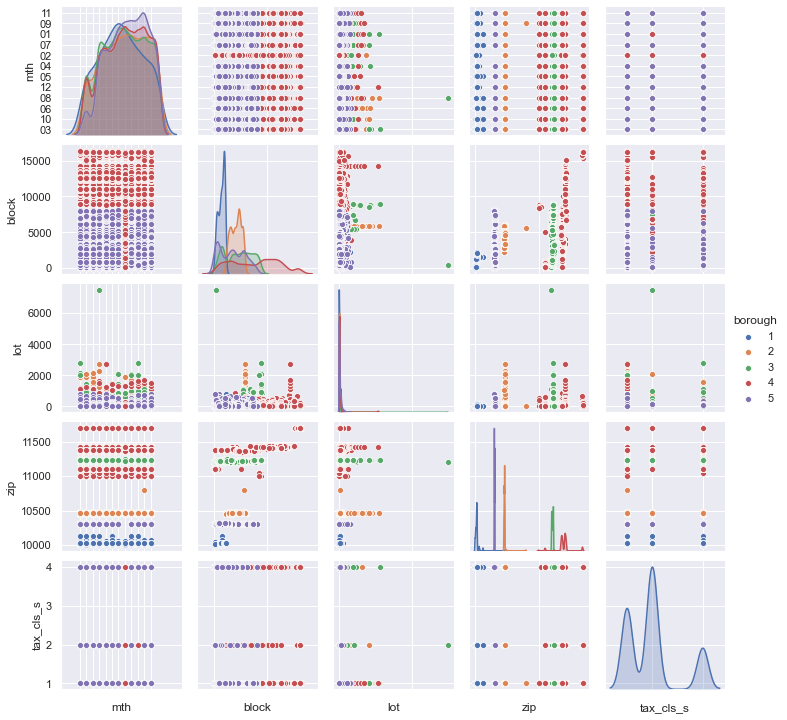

In [40]:
pairplot_all(df3, fac_features , 'borough')

In [135]:
df3["aux"] = 1
df3.columns

Index(['Sale_id', 'bbl_id', 'borough', 'bldg_ctgy', 'tax_cls_p', 'block',
       'lot', 'bldg_cls_p', 'zip', 'res_unit', 'com_unit', 'tot_unit',
       'land_sqft', 'tot_sqft', 'yr_built', 'tax_cls_s', 'bldg_cls_s',
       'sale_date', 'price', 'long', 'lat', 'mth', 'price_trans', 'aux'],
      dtype='object')

## 2. Feature engineering (categorical features)

### 2.1.1 Using one-hot encoding for categorical features

In [42]:
# one-hot encoding

def get_oh_df(dataframe, factor_list):
    for factor in factor_list:
        dataframe = pd.concat([dataframe, pd.get_dummies(dataframe[factor])], axis = 1) 
        dataframe = dataframe.drop(factor, axis = 1)

    return dataframe

In [59]:
# label encoding 

keep_list = ["price_trans", 'tot_unit', 'tot_sqft', # numerical
             "bldg_ctgy"] #factoral

df4 = df3[keep_list]

encode_list = ["bldg_ctgy"]

df_oh = get_oh_df(df4, encode_list)
df_oh.head()

,price_trans,tot_unit,tot_sqft,01 ONE FAMILY DWELLINGS,02 TWO FAMILY DWELLINGS,03 THREE FAMILY DWELLINGS,05 TAX CLASS 1 VACANT LAND,06 TAX CLASS 1 - OTHER,07 RENTALS - WALKUP APARTMENTS,08 RENTALS - ELEVATOR APARTMENTS,...,26 OTHER HOTELS,27 FACTORIES,29 COMMERCIAL GARAGES,30 WAREHOUSES,32 HOSPITAL AND HEALTH FACILITIES,33 EDUCATIONAL FACILITIES,35 INDOOR PUBLIC AND CULTURAL FACILITIES,37 RELIGIOUS FACILITIES,38 ASYLUMS AND HOMES,41 TAX CLASS 4 - OTHER
4,60.975396,2,2452,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,61.936607,2,2400,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,26.547867,2,2400,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,64.123907,2,2394,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,63.708303,3,3240,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.1.2 Using mean encoding

In [44]:
keep_list = ["price_trans", 'com_unit', 'tot_unit', 'tot_sqft', 'land_sqft',  # numerical
             'bldg_ctgy', 'tax_cls_p', 'bldg_cls_p', 'bldg_cls_s', 'sale_date', 'borough', 'zip', 'tax_cls_s'] #factoral

df_me = df3[keep_list]

encode_list = ['bldg_ctgy', 'tax_cls_p', 'bldg_cls_p', 'bldg_cls_s', 'sale_date', 'borough', 'zip', 'tax_cls_s' ]

for c in encode_list:
    mean_df = df_me.groupby(c)['price_trans'].mean().reset_index()
    mean_df.columns = [c, f'{c}_mean']
    df_me = pd.merge(df_me, mean_df, on=c, how='left')
    df_me = df_me.drop(c, axis=1)
    
df_me.head()

,price_trans,com_unit,tot_unit,tot_sqft,land_sqft,bldg_ctgy_mean,tax_cls_p_mean,bldg_cls_p_mean,bldg_cls_s_mean,sale_date_mean,borough_mean,zip_mean,tax_cls_s_mean
0,60.975396,1,2,2452,2500,63.555942,65.181885,67.933418,67.946945,68.158025,61.214512,61.501787,65.185258
1,61.936607,0,2,2400,2000,66.213153,65.181885,66.926053,66.924718,67.381280,61.214512,61.970823,65.185258
2,26.547867,0,2,2400,2000,66.213153,65.181885,66.926053,66.924718,67.278812,61.214512,61.970823,65.185258
3,64.123907,0,2,2394,3165,66.213153,65.181885,66.926053,66.924718,65.573188,61.214512,61.970823,65.185258
4,63.708303,1,3,3240,1620,66.213153,65.181885,70.164621,70.164621,65.819858,61.214512,61.970823,65.185258


### 2.1.3 Using mean encoding + group by encoding

In [45]:
keep_list = ["price_trans", "Sale_id", 'com_unit', 'tot_unit', 'tot_sqft', 'land_sqft',  # numerical
             'bldg_ctgy', 'tax_cls_p', 'bldg_cls_p', 'bldg_cls_s', 'sale_date', 'borough', 'zip', 'tax_cls_s'] #factoral

df_gp = df3[keep_list]

mean_df = df_gp.groupby(["borough", "bldg_ctgy"]).price_trans.mean().reset_index()
median_df = df_gp.groupby(["borough", "bldg_ctgy"]).price_trans.median().reset_index()
max_df = df_gp.groupby(["borough", "bldg_ctgy"]).price_trans.max().reset_index()

temp = pd.concat([mean_df, median_df], axis =1)
temp = pd.concat([temp, max_df], axis = 1)
temp.columns = ['borough', 'bldg_ctgy', 'gp_mean', 'drop', 'drop', 'gp_median', 'drop','drop', 'gp_max']
temp = temp.drop('drop', axis = 1)
temp.head()

,borough,bldg_ctgy,gp_mean,gp_median,gp_max
0,1,01 ONE FAMILY DWELLINGS,99.400635,102.528001,121.825874
1,1,02 TWO FAMILY DWELLINGS,96.637057,97.946207,121.825874
2,1,03 THREE FAMILY DWELLINGS,89.183049,86.920814,117.214600
3,1,07 RENTALS - WALKUP APARTMENTS,95.876122,99.952846,121.704857
4,1,08 RENTALS - ELEVATOR APARTMENTS,102.567227,110.734032,114.556185


In [49]:
temp["match"] = temp["borough"].astype(str) + "-" + temp["bldg_ctgy"].astype(str)
df_gp["match"] = df_gp["borough"].astype(str) + "-" + df_gp["bldg_ctgy"].astype(str)

df_gp = pd.merge(df_gp, temp, on = "match")
df_gp = df_gp.drop(["borough_y", "bldg_ctgy_y", 'match'], axis = 1)
df_gp.head()

<ipython-input-49-8f05c824e0f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gp["match"] = df_gp["borough"].astype(str) + "-" + df_gp["bldg_ctgy"].astype(str)


,price_trans,Sale_id,com_unit,tot_unit,tot_sqft,land_sqft,bldg_ctgy_x,tax_cls_p,bldg_cls_p,bldg_cls_s,sale_date,borough_x,zip,tax_cls_s,gp_mean,gp_median,gp_max
0,60.975396,5,1,2,2452,2500,01 ONE FAMILY DWELLINGS,1,S1,S1,01-07-15,2,10458,1,58.914087,59.954648,86.02821
1,41.885398,96,0,1,1512,1494,01 ONE FAMILY DWELLINGS,1,A5,A5,19-03-15,2,10469,1,58.914087,59.954648,86.02821
2,41.885398,97,0,1,1512,1494,01 ONE FAMILY DWELLINGS,1,A5,A5,16-03-15,2,10469,1,58.914087,59.954648,86.02821
3,57.352845,98,0,1,1386,1914,01 ONE FAMILY DWELLINGS,1,A5,A5,30-03-15,2,10469,1,58.914087,59.954648,86.02821
4,60.537482,99,0,1,1732,1710,01 ONE FAMILY DWELLINGS,1,A5,A5,31-08-15,2,10469,1,58.914087,59.954648,86.02821


In [50]:
encode_list = ['tax_cls_p', 'bldg_ctgy_x', 'bldg_cls_s', 'sale_date', 'borough_x', 'zip', 'tax_cls_s',]

for c in encode_list:
    mean_df = df_gp.groupby(c)['price_trans'].mean().reset_index()
    mean_df.columns = [c, f'{c}_mean']
    df_gp = pd.merge(df_gp, mean_df, on=c, how='left')
    df_gp = df_gp.drop(c, axis=1)
    
df_gp.head()

,price_trans,Sale_id,com_unit,tot_unit,tot_sqft,land_sqft,bldg_cls_p,gp_mean,gp_median,gp_max,tax_cls_p_mean,bldg_ctgy_x_mean,bldg_cls_s_mean,sale_date_mean,borough_x_mean,zip_mean,tax_cls_s_mean
0,60.975396,5,1,2,2452,2500,S1,58.914087,59.954648,86.02821,65.181885,63.555942,67.946945,68.158025,61.214512,61.501787,65.185258
1,41.885398,96,0,1,1512,1494,A5,58.914087,59.954648,86.02821,65.181885,63.555942,62.325327,66.225859,61.214512,60.288545,65.185258
2,41.885398,97,0,1,1512,1494,A5,58.914087,59.954648,86.02821,65.181885,63.555942,62.325327,66.266174,61.214512,60.288545,65.185258
3,57.352845,98,0,1,1386,1914,A5,58.914087,59.954648,86.02821,65.181885,63.555942,62.325327,64.862934,61.214512,60.288545,65.185258
4,60.537482,99,0,1,1732,1710,A5,58.914087,59.954648,86.02821,65.181885,63.555942,62.325327,66.598245,61.214512,60.288545,65.185258


# 3 Validate in different model settings

### 3.1 Base model with regression 

In [160]:
def evaluate_base_model(dataframe, model):
    # Split the train/test dataset
    
    train_data, test_data = train_test_split(dataframe, random_state=777, train_size=0.8)
    
    # Extract the predictiob target 
    train_y = stats.boxcox(train_data.price, lmbda=0.2)
    train_x = train_data.drop("price", axis = 1)
    test_y = stats.boxcox(test_data.price, lmbda=0.2)
    test_x = test_data.drop("price", axis = 1)
    
    # Build the model and fit it
    model.fit(train_x, train_y)
    pred_y =model.predict(test_x)
    
    # Estimations
    r2 = round(r2_score(test_y, pred_y),4)
    adjusted_r2 = round(1 - (1-metrics.r2_score(test_y, pred_y))*(len(test_y)-1)/(len(test_y)-train_x.shape[1]-1),4)
    mae = round(metrics.mean_absolute_error(test_y, pred_y),4)
    mse = round(metrics.mean_squared_error(test_y, pred_y),4)
    
    # print
    print(f"Estimations for {model}:")
    print("R2:", r2)
    print('Adjusted R2:',adjusted_r2)
    print('MAE:',mae)
    print('MSE:',mse)

In [195]:

evaluate_base_model(df_base, LinearRegression())

Estimations for LinearRegression():
R2: 0.124
Adjusted R2: 0.1237
MAE: 9.1751
MSE: 176.1866


## 3.2  Cross validate using different regression algorithms

In [51]:
def cross_validate(dataframe, model):

    # Extract the prediction target 
    train_y = dataframe.price_trans
    train_x = dataframe.drop("price_trans", axis = 1)
    
    print(f'R2 score : {cross_val_score(model, train_x, train_y, cv=5, scoring = "r2").mean()}')
    print(f'MAE : {-(cross_val_score(model, train_x, train_y, cv=5, scoring = "neg_mean_absolute_error").mean())}')
    print(f'MSE : {-(cross_val_score(model, train_x, train_y, cv=5, scoring = "neg_mean_squared_error").mean())}')

In [61]:
# one hot encoding 

cross_validate(df_oh, LinearRegression())
print("\n")
cross_validate(df_oh, GradientBoostingRegressor())

R2 score : 0.08048165072341387
MAE : 7.378320230490656
MSE : 115.1757001235723


R2 score : 0.12411022756188572
MAE : 7.188294932833619
MSE : 108.25691914851419


In [200]:
# label encloding 

cross_validate(df_label, LinearRegression())
print('\n')
evaluate_model(df_label, SVR(kernel = "poly", degree  = 2)) 
print('\n')
evaluate_model(df_label, SVR(kernel = "rbf"))
print('\n')
cross_validate(df_label, GradientBoostingRegressor())

R2 score : -1.362966793467908
MAE : 10.652447095306808
MSE : 202.4919405102966


Estimations for SVR(degree=2, kernel='poly'):
R2: 0.1362
Adjusted R2: 0.1341
MAE: 7.23
MSE: 120.6648


Estimations for SVR():
R2: 0.2966
Adjusted R2: 0.295
MAE: 6.7199
MSE: 98.2496


R2 score : -0.43344562239587886
MAE : 8.481555037737389
MSE : 150.80312462438957


In [199]:
# mean encoding 

cross_validate(df_me, LinearRegression())
print('\n')
evaluate_model(df_me, SVR(kernel = "poly", degree  = 2)) 
print('\n')
evaluate_model(df_me, SVR(kernel = "rbf"))
print('\n')
cross_validate(df_me, GradientBoostingRegressor())

R2 score : 0.4871559112617674
MAE : 4.9203098121208075
MSE : 61.151425070239455


Estimations for SVR(kernel='poly'):
R2: 0.2118
Adjusted R2: 0.2099
MAE: 7.0885
MSE: 110.1007


Estimations for SVR():
R2: 0.3005
Adjusted R2: 0.2988
MAE: 6.7324
MSE: 97.7082


R2 score : 0.48519344308996964
MAE : 4.971274726575242
MSE : 61.17495294525245


In [159]:
# group by encoding + mean encoding 

cross_validate(df_gp, LinearRegression())
print('\n')
evaluate_model(df_gp, SVR(kernel = "poly", degree  = 3)) 
print('\n')
evaluate_model(df_gp, SVR(kernel = "rbf"))
print('\n')
cross_validate(df_gp, GradientBoostingRegressor())

R2 score : 0.5141330507290343
MAE : 4.87442229255073
MSE : 59.99520669748929


Estimations for SVR(kernel='poly'):
R2: 0.2286
Adjusted R2: 0.2263
MAE: 7.1366
MSE: 115.2608


Estimations for SVR():
R2: 0.3091
Adjusted R2: 0.307
MAE: 6.8529
MSE: 103.2431


R2 score : 0.5084984877471059
MAE : 4.969279405657749
MSE : 60.63544158732515


# 4 Test final model in the test dataset 

In [218]:
train_data, test_data = train_test_split(df_gp, random_state=777, train_size=0.8)

train_y = train_data.price_trans
train_x = train_data.drop("price_trans", axis = 1)
test_y = test_data.price_trans
test_x = test_data.drop("price_trans", axis = 1)

model = GradientBoostingRegressor()
model.fit(train_x, train_y)
pred_y = model.predict(test_x)
    
r2 = round(r2_score(test_y, pred_y),4)
mae = round(metrics.mean_absolute_error(test_y, pred_y),4)
mse = round(metrics.mean_squared_error(test_y, pred_y),4)
    
print("R2:", r2)
print('MAE:',mae)
print('MSE:',mse)

R2: 0.5966
MAE: 4.8102
MSE: 60.2758


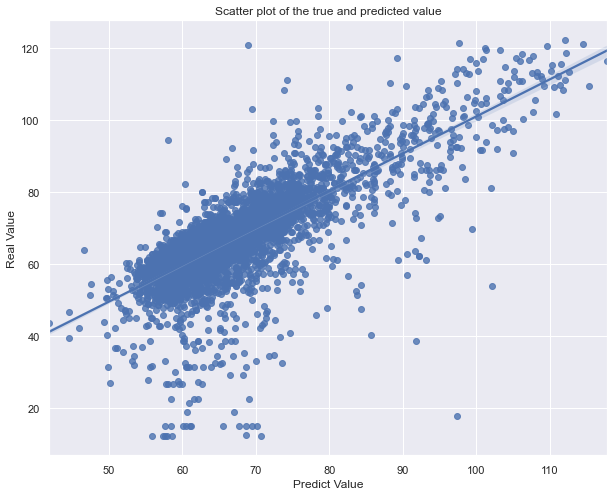

In [236]:
plt.subplots(figsize=(10,8))
ax = sns.regplot(pred_y, test_y)
ax = plt.xlabel("Predict Value")
ax = plt.ylabel("Real Value") 
ax = plt.title("Scatter plot of the true and predicted value")

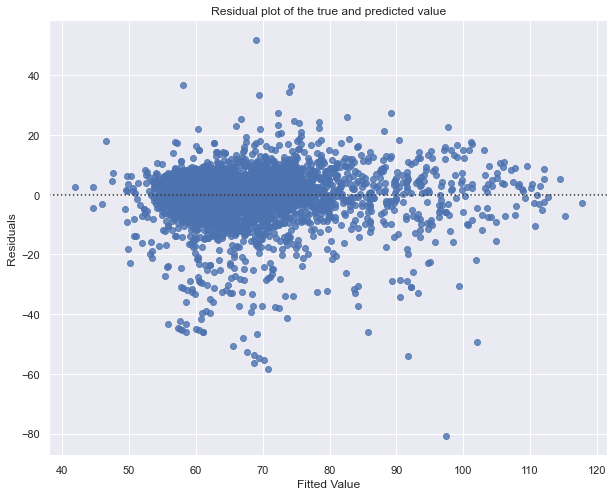

In [238]:
plt.subplots(figsize=(10,8))
ax = sns.residplot(pred_y, test_y)
ax = plt.xlabel("Fitted Value")
ax = plt.ylabel("Residuals") 
ax = plt.title("Residual plot of the true and predicted value")

In [220]:
print(f'R2 score : {cross_val_score(GradientBoostingRegressor(), train_x, train_y, cv=5, scoring = "r2").mean()}')
print(f'MAE : {-(cross_val_score(GradientBoostingRegressor(), train_x, train_y, cv=5, scoring = "neg_mean_absolute_error").mean())}')
print(f'MSE : {-(cross_val_score(GradientBoostingRegressor(), train_x, train_y, cv=5, scoring = "neg_mean_squared_error").mean())}')

R2 score : 0.6060704534182
MAE : 4.702211718935348
MSE : 56.50405180432733


In [214]:
def evaluate_model(dataframe, model):

    # Split the train/test dataset
    
    train_data, test_data = train_test_split(dataframe, random_state=777, train_size=0.8)
    
    # Extract the predictiob target 
    
    train_y = train_data.price_trans
    train_x = train_data.drop("price_trans", axis = 1)
    test_y = test_data.price_trans
    test_x = test_data.drop("price_trans", axis = 1)

    # Build the model and fit it
    model.fit(train_x, train_y)
    pred_y =model.predict(test_x)
    
    # Estimations
    r2 = round(r2_score(test_y, pred_y),4)
    adjusted_r2 = round(1 - (1-metrics.r2_score(test_y, pred_y))*(len(test_y)-1)/(len(test_y)-train_x.shape[1]-1),4)
    mae = round(metrics.mean_absolute_error(test_y, pred_y),4)
    mse = round(metrics.mean_squared_error(test_y, pred_y),4)
    
    # print
    print(f"Estimations for {model}:")
    print("R2:", r2)
    print('Adjusted R2:',adjusted_r2)
    print('MAE:',mae)
    print('MSE:',mse)